In [17]:
from scipy.optimize import minimize
from Truss_2D import Truss_2D
import numpy as np
from random import random
import matplotlib.pyplot as plt 

### Step 1: Initialize Design Variables

In [18]:
area_old = 50

### Step 2.1: Define Model Analysis

In [19]:
def Truss_solver(cross_sectional_areas):
    nodes = {1: [720,360], 2:[720,0], 3:[360,360], 4:[360,0], 5:[0,360], 6:[0,0]}
    elements = {1:[5,3], 2:[3,1], 3:[6,4], 4:[4,2], 5:[3,4], 6:[1,2], 7:[5,4], 8:[6,3], 9:[3,2], 10:[4,1]}
    supports = {5:[1,1], 6:[1,1]}
    forces = {2:[0,-100], 4:[0,-100]}
    elasticity = {key: 10_000 for key in elements}
    cross_area = {1:cross_sectional_areas[0], 2:cross_sectional_areas[1], 3:cross_sectional_areas[2], 4:cross_sectional_areas[3], 5:cross_sectional_areas[4],
                  6:cross_sectional_areas[5], 7:cross_sectional_areas[6], 8:cross_sectional_areas[7], 9:cross_sectional_areas[8], 10:cross_sectional_areas[9]}

    Ten_Bar_Truss_Case_1 = Truss_2D(nodes = nodes,
                                    elements= elements,
                                    supports= supports,
                                    forces = forces,
                                    elasticity= elasticity,
                                    cross_area= cross_area)

    Ten_Bar_Truss_Case_1.Solve()

    return (Ten_Bar_Truss_Case_1.member_lengths_, Ten_Bar_Truss_Case_1.member_stresses_, Ten_Bar_Truss_Case_1.displacements_)

#### Step 2.2: Define Objective Function

In [20]:
def Objective_Function(areas):
    
    member_lengths, member_stresses, node_displacements = Truss_solver(areas)    
    total_area = np.array(areas)
    total_member_lengths = []
    
    for length in member_lengths:
        total_member_lengths.append(member_lengths[length])

    total_member_lengths = np.array(total_member_lengths)

    weight = total_area.dot(np.array(total_member_lengths))

    weight = weight.sum() * 0.1 # lb/in^3

    return (weight, member_stresses, node_displacements)

#### Step 2.3: Define Constraints

In [21]:
def stress_constraint(stresses_new):
    stress_counter = []
    
    for stress in range(1,len(stresses_new)+1):
        if stresses_new[stress] >= 25 or stresses_new[stress] <= -25:
            stress_counter.append(1)
        else:
            stress_counter.append(0)
    
    return sum(stress_counter)

In [22]:
def displacement_constraint(node_displacement_new):
    displacement_counter = []
    
    for displacement in range(1,len(node_displacement_new)+1):
        x = node_displacement_new[displacement][0]
        y = node_displacement_new[displacement][1]
        if x >= 2 or x <= -2:
            displacement_counter.append(1)
        elif y >= 2 or y <= -2:
            displacement_counter.append(1)
        else:
            displacement_counter.append(0)

    return sum(displacement_counter)

### Step 3: Define Algorithm

Step 3.1: Initialize Parameters

In [23]:
# intermediate variables 
k = 0.05 # move variable's constant
M = 500 # number of loops to be performed
T0 = 5000 # initial temperature
N = 20 # initial number of neighbors per search space loop
alpha = 0.85 # cooling parameter

In [24]:
temp = [] # storing of values for the temperature per loop M
min_weight = [] # storing best value of the objective function per loop M
area_list = [] # storing x values per loop for plotting purposes

Step 3.2: Simulated Annealing Algorithm

In [25]:
def Random_Number_Check(objective_old, objective_new, Init_temp):
    return 1/((np.exp(objective_old - objective_new)) / Init_temp)

In [26]:
%%time 
for m in range(M):
    for n in range(N):

        random_area = random()
        
        if random_area >= 0.5:
            area_new = k*random_area
        else:
            area_new = -k*random_area  

        area_new = area_old + area_new

        areas_new_array = [area_new for i in range(10)]
        areas_old_array = [area_old for i in range(10)]

        weight_computed, stresses_new, node_displacement_new = Objective_Function(areas_new_array)
        weight_old, _, _ = Objective_Function(areas_old_array)

        check = Random_Number_Check(weight_computed, weight_old, T0)
        random_number = random()

        # Contraint 1: stresses should be within 25ksi and -25ksi
        stress_counter = stress_constraint(stresses_new)     

        # Constraint 2: Node Displacement should be limited to -2in and 2in
        displacement_counter = displacement_constraint(node_displacement_new)

        if stress_counter >= 1 or displacement_counter >=1:
            area_old = area_old
        else:        
            if weight_computed <= weight_old:
                area_old = area_new
            elif random_number <= check:
                area_old = area_new
            else:
                area_old = area_old

    temp.append(T0)
    min_weight.append(weight_old)
    area_list.append(area_old)
    
    T0 = alpha * T0

Wall time: 25.3 s


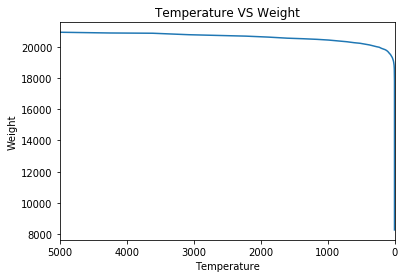

In [27]:
plt.xlim(5000,0)
plt.xlabel('Temperature')
plt.ylabel('Weight')
plt.title('Temperature VS Weight')
plt.plot(temp, min_weight)

In [28]:
area_list[-1]

19.697929220794038

In [29]:
nodes = {1: [720,360], 2:[720,0], 3:[360,360], 4:[360,0], 5:[0,360], 6:[0,0]}
elements = {1:[5,3], 2:[3,1], 3:[6,4], 4:[4,2], 5:[3,4], 6:[1,2], 7:[5,4], 8:[6,3], 9:[3,2], 10:[4,1]}
supports = {5:[1,1], 6:[1,1]}
forces = {2:[0,-100], 4:[0,-100]}
elasticity = {key: 10_000 for key in elements}
cross_area = {key: area_list[-1] for key in range(1,11)}

Ten_Bar_Truss_Case_1 = Truss_2D(nodes = nodes,
                                elements= elements,
                                supports= supports,
                                forces = forces,
                                elasticity= elasticity,
                                cross_area= cross_area)

Ten_Bar_Truss_Case_1.Solve()

In [30]:
Ten_Bar_Truss_Case_1.displacements_

{1: [0.43038, -1.92666],
 2: [-0.48342, -1.99999],
 3: [0.35705, -0.85001],
 4: [-0.37399, -0.91488],
 5: [0.0, 0.0],
 6: [0.0, 0.0]}

In [31]:
Ten_Bar_Truss_Case_1.member_stresses_

{1: 9.91806,
 2: 2.03694,
 3: -10.38861,
 4: -3.03972,
 5: 1.80194,
 6: 2.03694,
 7: 7.51236,
 8: -6.84667,
 9: 4.29875,
 10: -2.88069}

In [32]:
weight, _, _ = Objective_Function([area_list[-1] for i in range(10)])
weight

8266.172037970073